**Kursarbeit Datenmanagement und -Archivierung WS 23/24**

Master-Code Name-CALICO:MA


**Explorative Datenanalyse**

> Laden Libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive



> Verbindung zur Datenbank



In [3]:
#connect to DB
conn = sqlite3.connect('/content/drive/My Drive/Datenmanagement_und_Archivierung_im_Umfeld_der_Forschung/CALICO_MA/datawarehouse.db')
cursor = conn.cursor()

print("Datenbank wurde erfolgreich geöffnet")

Datenbank wurde erfolgreich geöffnet


In [ ]:
print(pd.read_sql_query('''
SELECT name FROM sqlite_master
WHERE type='table'
ORDER BY name;
     ''', conn))

              name
0       encounters
1      facts_table
2    immunizations
3      medications
4     observations
5         patients
6       procedures
7  sqlite_sequence



> Laden die Daten aus der Datenbank in die DataFrames für die weitere Analyse



In [4]:
df_encounters = pd.read_sql_query("SELECT * FROM encounters", conn)
df_facts_table = pd.read_sql_query("SELECT * FROM facts_table", conn)
df_immunizations = pd.read_sql_query("SELECT * FROM immunizations", conn)
df_medications = pd.read_sql_query("SELECT * FROM medications", conn)
df_observations = pd.read_sql_query("SELECT * FROM observations", conn)
df_patients = pd.read_sql_query("SELECT * FROM patients", conn)
df_procedures = pd.read_sql_query("SELECT * FROM procedures", conn)

cancer_type
breast_cancer        1019
colorectal_cancer    1035
lung_cancer          1030
Name: Id, dtype: int64


<Axes: xlabel='cancer_type'>

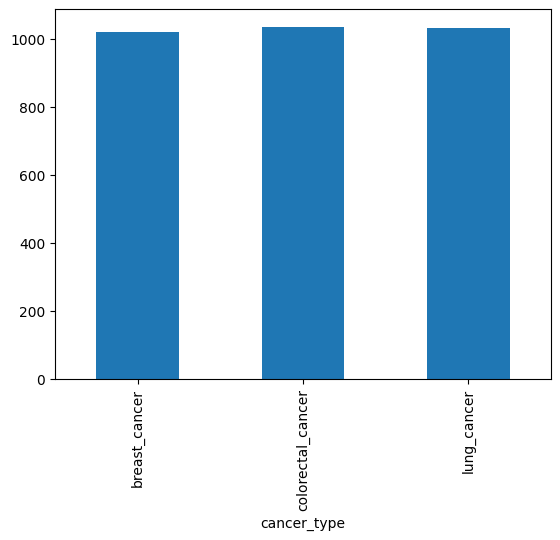

In [5]:
df2 = df_patients.groupby(['cancer_type'])['Id'].count()
print(df2)
df2.plot.bar()

In [6]:
# facts_table is not loading data in many columns
df3 = df_facts_table.head(3)
print(df3)

     cancer_type                            patient_ID encounter_ID  \
0  breast_cancer  d2061cc7-bee0-0e6c-3ac4-15c197c474e0         None   
1  breast_cancer  d2061cc7-bee0-0e6c-3ac4-15c197c474e0         None   
2  breast_cancer  d2061cc7-bee0-0e6c-3ac4-15c197c474e0         None   

    patient_LAT    patient_LON patient_HEALTHCARE_EXPENSES  \
0  42,359925869  -71,113260249                     1475230   
1  42,359925869  -71,113260249                     1475230   
2  42,359925869  -71,113260249                     1475230   

  patient_HEALTHCARE_COVERAGE patient_BIRTHDATE observations_VALUE  \
0                     4244,64        22/06/1956               None   
1                     4244,64        22/06/1956               None   
2                     4244,64        22/06/1956               None   

  observations_DATE procedures_BASE_COST medications_TOTALCOST  \
0              None                 None                  None   
1              None                 None             

Abbildungen

1.   Kosten fur jeder krebsarten (Insgesamt)
2.   Kosten fur jeder krebsarten (getrennt)
3.   Life quality (QALY) mit kosten korrelieren (Insgesamt) (death date not available)
4.   Life quality (QALY) mit kosten korrelieren (getrennt)
5.   Verhaltnis QALY - aktuelle alter (von BIRTHDATE (patients))
6.   Statistiche auswertung

#Abbildung 1

In [ ]:
#Abbildung 1
#Query for cost comparison between cancer types (inluding joins because facts_table is not properly populated)
#Use this code in case expenses and coverage wants to be included "COALESCE(CAST(f.patient_HEALTHCARE_EXPENSES AS DECIMAL(6,2)), 0) + COALESCE(CAST(f.patient_HEALTHCARE_COVERAGE AS DECIMAL(6,2)), 0)"
query_1 = """
    SELECT
        f.cancer_type,
        SUM(
            COALESCE(CAST(f.procedures_BASE_COST AS DECIMAL(6,2)), 0) +
            COALESCE(CAST(f.medications_TOTALCOST AS DECIMAL(6,2)), 0) +
            COALESCE(CAST(f.immunizations_BASE_COST AS DECIMAL(6,2)), 0) +
            COALESCE(CAST(f.encounter_BASE_ENCOUNTER_COST AS DECIMAL(6,2)), 0)
        ) AS total_cost
    FROM facts_table f
    LEFT JOIN patients p ON f.patient_ID = p.Id
    LEFT JOIN procedures pr ON f.patient_ID = pr.PATIENT AND f.encounter_ID = pr.ENCOUNTER
    LEFT JOIN medications m ON f.patient_ID = m.PATIENT AND f.encounter_ID = m.ENCOUNTER
    LEFT JOIN immunizations i ON f.patient_ID = i.PATIENT AND f.encounter_ID = i.ENCOUNTER
    LEFT JOIN encounters e ON f.patient_ID = e.PATIENT AND f.encounter_ID = e.Id
    GROUP BY f.cancer_type;
"""

# Execute the query and fetch the results into a Pandas DataFrame
df = pd.read_sql_query(query_1, conn)
print(df.head())


         cancer_type  total_cost
0      breast_cancer    37870275
1  colorectal_cancer    61022688
2        lung_cancer    40279895


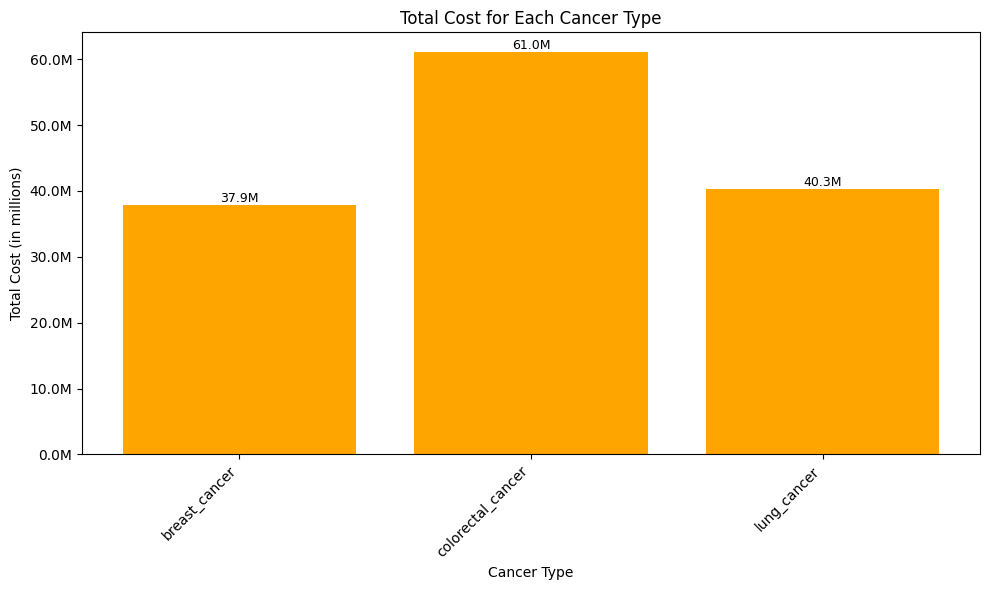

In [ ]:
df['cancer_type'] = df['cancer_type'].fillna('Unknown')  # Replace None with 'Unknown'

cancer_types = df['cancer_type']
total_costs = df['total_cost']

# Plotting the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(cancer_types, total_costs, color='orange')
plt.xlabel('Cancer Type')
plt.ylabel('Total Cost (in millions)')
plt.title('Total Cost for Each Cancer Type')

# Format y-axis ticks to display values in millions
formatter = FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)

# Add exact value in million dollars on top of each column
for bar, cost in zip(bars, total_costs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{cost / 1e6:.1f}M', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

#Abbildung 2
Below code not working for all joins, there is not enough RAM capacity


query_2 ="""
SELECT
      patient_ID,
      facts_table.cancer_type,
      encounters.BASE_ENCOUNTER_COST AS encounters_BASE_ENCOUNTER_COST,
      immunizations.BASE_COST AS immunizations_BASE_COST,
      procedures.BASE_COST AS procedures_BASE_COST,
      observations.VALUE AS observation_VALUE,
      medications.TOTALCOST AS medications_TOTALCOST
FROM facts_table
      LEFT JOIN encounters ON facts_table.patient_ID = encounters.PATIENT
      LEFT JOIN immunizations ON facts_table.patient_ID = immunizations.PATIENT
      LEFT JOIN procedures ON facts_table.patient_ID = procedures.PATIENT
      LEFT JOIN observations ON facts_table.patient_ID = observations.PATIENT
      LEFT JOIN medications ON facts_table.patient_ID = medications.PATIENT
GROUP BY facts_table.cancer_type;
"""

df = pd.read_sql_query(query_2, conn)
print(df.head())


In [ ]:
#Abbildung 2
#
query_2 ="""SELECT
      patient_ID,
      f.cancer_type,
      encounters.BASE_ENCOUNTER_COST AS encounters_BASE_ENCOUNTER_COST,
      immunizations.BASE_COST AS immunizations_BASE_COST,
      procedures.BASE_COST AS procedures_BASE_COST
FROM facts_table f
LEFT JOIN encounters ON f.patient_ID = encounters.PATIENT
LEFT JOIN immunizations ON f.patient_ID = immunizations.PATIENT
LEFT JOIN procedures ON f.patient_ID = procedures.PATIENT
GROUP BY f.cancer_type;

"""
df = pd.read_sql_query(query_2, conn)
print(df.head())



                             patient_ID        cancer_type  \
0  d2061cc7-bee0-0e6c-3ac4-15c197c474e0      breast_cancer   
1  3f4ba8c9-bd19-30d2-0ec0-a2ab7bb1d430  colorectal_cancer   
2  6c9b1cca-a9a5-c846-db94-c68714112d82        lung_cancer   

  encounters_BASE_ENCOUNTER_COST immunizations_BASE_COST procedures_BASE_COST  
0                         129,16                  140,52                 None  
1                         129,16                  140,52                 None  
2                         129,16                  140,52              1065,57  


<ipython-input-26-3beffad00fd9>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=breast_cancer_df[cost_columns], ci=None)
<ipython-input-26-3beffad00fd9>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=colorectal_cancer_df[cost_columns], ci=None)
<ipython-input-26-3beffad00fd9>:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=lung_cancer_df[cost_columns], ci=None)


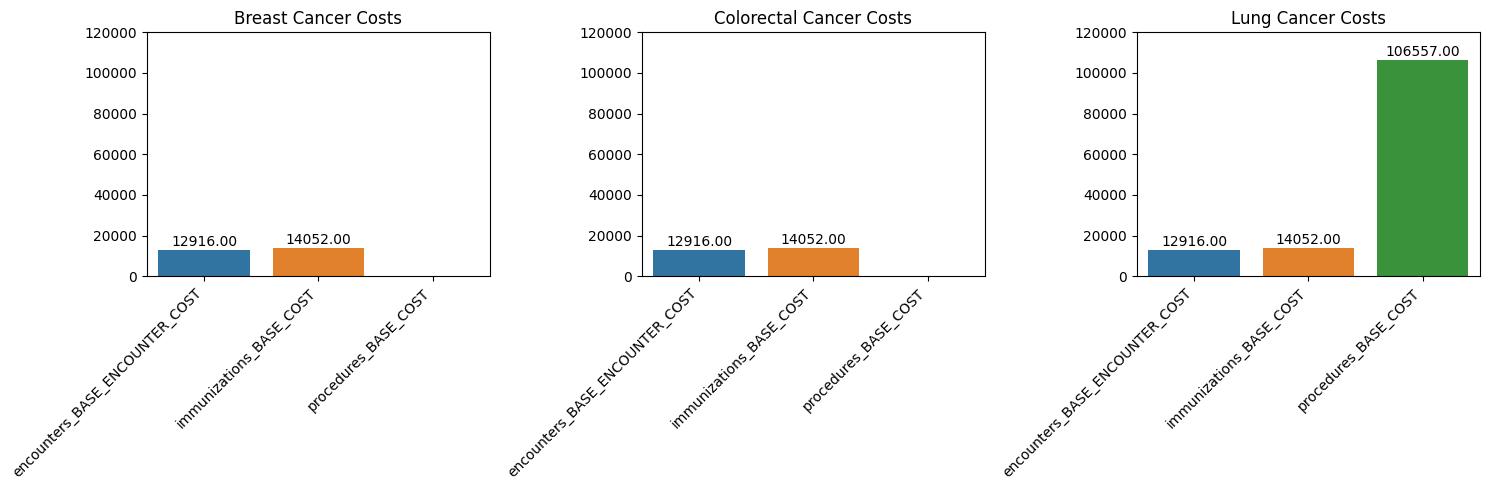

In [ ]:
df['encounters_BASE_ENCOUNTER_COST'] = df['encounters_BASE_ENCOUNTER_COST'].astype(str)
df['immunizations_BASE_COST'] = df['immunizations_BASE_COST'].astype(str)
df['procedures_BASE_COST'] = df['procedures_BASE_COST'].astype(str)

# Define a function to clean and convert to numeric
def clean_and_convert(value):
    try:
        return pd.to_numeric(value.replace(',', ''), errors='coerce')
    except AttributeError:
        return value

# Apply the function to the cost columns
df['encounters_BASE_ENCOUNTER_COST'] = df['encounters_BASE_ENCOUNTER_COST'].apply(clean_and_convert)
df['immunizations_BASE_COST'] = df['immunizations_BASE_COST'].apply(clean_and_convert)
df['procedures_BASE_COST'] = df['procedures_BASE_COST'].apply(clean_and_convert)

# Create separate DataFrames for each cancer type
breast_cancer_df = df[df['cancer_type'] == 'breast_cancer']
colorectal_cancer_df = df[df['cancer_type'] == 'colorectal_cancer']
lung_cancer_df = df[df['cancer_type'] == 'lung_cancer']

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Breast Cancer
plt.subplot(1, 3, 1)
sns.barplot(data=breast_cancer_df[cost_columns], ci=None)
plt.title('Breast Cancer Costs')
plt.ylim(0, 120000)  # Set y-axis limits
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
for i, val in enumerate(breast_cancer_df[cost_columns].mean()):
    plt.text(i, val + 500, f'{val:.2f}', ha='center', va='bottom')

# Plot 2: Colorectal Cancer
plt.subplot(1, 3, 2)
sns.barplot(data=colorectal_cancer_df[cost_columns], ci=None)
plt.title('Colorectal Cancer Costs')
plt.ylim(0, 120000)  # Set y-axis limits
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
for i, val in enumerate(colorectal_cancer_df[cost_columns].mean()):
    plt.text(i, val + 500, f'{val:.2f}', ha='center', va='bottom')

# Plot 3: Lung Cancer
plt.subplot(1, 3, 3)
sns.barplot(data=lung_cancer_df[cost_columns], ci=None)
plt.title('Lung Cancer Costs')
plt.ylim(0, 120000)  # Set y-axis limits
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
for i, val in enumerate(lung_cancer_df[cost_columns].mean()):
    plt.text(i, val + 500, f'{val:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
df_facts_table_2 = pd.read_csv('/content/drive/My Drive/Datenmanagement_und_Archivierung_im_Umfeld_der_Forschung/CALICO_MA/Fact_table.csv', sep=",")
df_facts_table_2.head(3)

,observations_LASTDATE,patient_Id,encounters_Id,encounters_ENCOUNTERCLASS,encounters_CODE,encounters_DESCRIPTION,encounters_BASE_ENCOUNTER_COST,immunizations_CODE,immunizations_BASE_COST,patient_BIRTHDATE,...,medications_CODE,medications_DESCRIPTION,medications_BASE_COST,medications_TOTALCOST,cancer_type,observations_DESCRIPTION,observations_VALUE,procedures_CODE,procedures_DESCRIPTION,procedures_BASE_COST
0,21/09/2020 12:13:04,33add796-7b92-3c92-baf2-994960975888,e5919e33-1af5-a2dd-24a9-a849250c7419,wellness,162673000,General examination of patient (procedure),"129,16",140.0,"140,52",21/09/1966,...,NaN,NaN,0,0,lung_cancer,DALY,0,NaN,NaN,0
1,21/09/2020 12:13:04,33add796-7b92-3c92-baf2-994960975888,cab3ca52-7ebd-e7e3-1453-bfbd0ebdcc47,wellness,162673000,General examination of patient (procedure),"129,16",140.0,"140,52",21/09/1966,...,NaN,NaN,0,0,lung_cancer,DALY,0,NaN,NaN,0
2,21/09/2020 12:13:04,33add796-7b92-3c92-baf2-994960975888,bb5f961c-4c9d-5459-0f40-1afcaca9e358,wellness,162673000,General examination of patient (procedure),"129,16",121.0,"140,52",21/09/1966,...,NaN,NaN,0,0,lung_cancer,DALY,0,NaN,NaN,0
